## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from os import listdir
from datetime import datetime 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

## Download Dataset

**It will download the tar file of pix2pix dataset provided by EECS, UC Berkeley.**

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2022-06-24 09:34:59--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  2.48MB/s    in 2m 37s  

2022-06-24 09:37:37 (1.52 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



**Unzip the tar file in the current path**

In [ ]:
!tar -xzvf "./maps.tar.gz" 

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531.jpg
maps/train/532.jpg
maps/train/533.jpg
maps/train/534.jpg
maps/train/535.jpg
maps/train/536.jpg
maps/train/537.jpg
maps/train/538.jpg
maps/train/539.jpg
maps/train/54.jpg
maps/train/540.jpg
maps/train/541.jpg
maps/train/542.jpg
maps/train/543.jpg
maps/train/544.jpg
maps/train/545.jpg
maps/train/546.jpg
maps/train/547.jpg
maps/train/548.jpg
maps/train/549.jpg
maps/train/55.jpg
maps/train/550.jpg
maps/train/551.jpg
maps/train/552.jpg
maps/train/553.jpg
maps/train/554.jpg
maps/train/555.jpg
maps/train/556.jpg
maps/train/557.jpg
maps/train/558.jpg
ma

**Mount the google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load the dataset

In [ ]:
def load_dataset(path):
	source, target = [], []
	for file_name in listdir(path):
		img = load_img(path + file_name, target_size = (256,512))
		img = img_to_array(img)
		source_img, target_img = img[:, :256], img[:, 256:]
		source.append(source_img)
		target.append(target_img)
	return [np.asarray(source), np.asarray(target)]

**Save the source images and target images in the both variable as numpy array format**

In [ ]:
[source_img, target_img] = load_dataset('maps/train/')
print('Loaded: ', source_img.shape, target_img.shape)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


**Plot first three images from the loaded dataset**

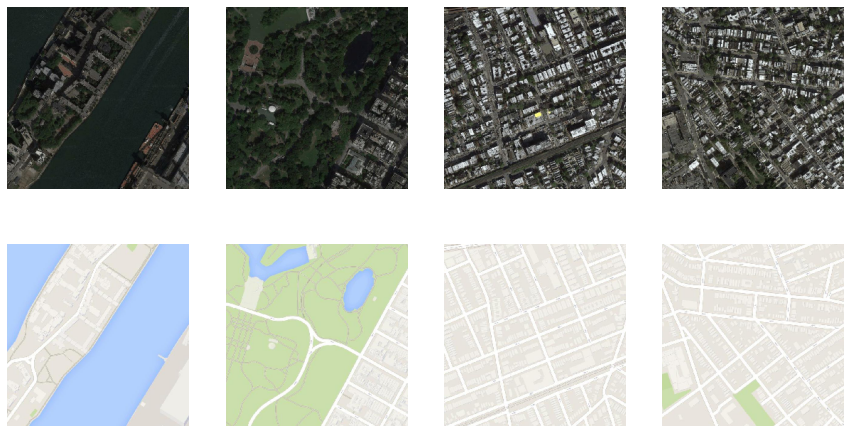

In [ ]:
plt.figure(figsize=(15,8))
for i in range(4): #source images
	plt.subplot(2, 4, 1 + i)
	plt.axis('off')
	plt.imshow(source_img[i].astype('uint8'))

for i in range(4): #target images
	plt.subplot(2, 4, 1 + 4 + i)
	plt.axis('off')
	plt.imshow(target_img[i].astype('uint8'))
plt.show()

### THE GENERATOR FUNCTION

**Here, the functional way is used for implementing the models instead of sequential method as we have multiple inputs.**

**In the generator function, the approach of encoder and decoder is applied in our Unet model.**

In [ ]:
def generator(img_shape=(256,256,3)):	
  init = RandomNormal(stddev = 0.02) # weight initialization
  input_img = Input(shape = img_shape) # image input
  
  #Encoders:
  g1 = Conv2D(64, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(input_img)
  g1 = LeakyReLU(alpha=0.2)(g1)
  g2 = Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(g1)
  g2 = BatchNormalization()(g2, training=True)
  g2 = LeakyReLU(alpha=0.2)(g2)
  g3 = Conv2D(256, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(g2)
  g3 = BatchNormalization()(g3, training=True)
  g3 = LeakyReLU(alpha=0.2)(g3)
  g4 = Conv2D(512, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(g3)
  g4 = BatchNormalization()(g4, training=True)
  g4 = LeakyReLU(alpha=0.2)(g4)
  g5 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g4)
  g5 = BatchNormalization()(g5, training=True)
  g5 = LeakyReLU(alpha=0.2)(g5)
  g6 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g5)
  g6 = BatchNormalization()(g6, training=True)
  g6 = LeakyReLU(alpha=0.2)(g6)    
  g7 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g6)
  g7 = BatchNormalization()(g7, training=True)
  g7 = LeakyReLU(alpha=0.2)(g7)
  g8 = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g7)
  g8 = BatchNormalization()(g8, training=True)
  g8 = LeakyReLU(alpha=0.2)(g8)
  #C64-C128-C256-C512-C512-C512-C512-C512
  
  #Decoders:
  g9 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g8)
  g9 = BatchNormalization()(g9, training=True)
  g9 = Dropout(0.5)(g9, training=True)
  g9 = Concatenate()([g9, g7])
  g9 = LeakyReLU(alpha=0.2)(g9)
  g10 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g9)
  g10 = BatchNormalization()(g10, training=True)
  g10 = Dropout(0.5)(g10, training=True)
  g10 = Concatenate()([g10, g6])
  g10 = LeakyReLU(alpha=0.2)(g10)
  g11 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g10)
  g11 = BatchNormalization()(g11, training=True)
  g11 = Dropout(0.5)(g11, training=True)
  g11 = Concatenate()([g11, g5])
  g11 = LeakyReLU(alpha=0.2)(g11)
  g12 = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g11)
  g12 = BatchNormalization()(g12, training=True)
  g12 = Dropout(0.5)(g12, training=True)
  g12 = Concatenate()([g12, g4])
  g12 = LeakyReLU(alpha=0.2)(g12)
  g13 = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g12)
  g13 = BatchNormalization()(g13, training=True)
  g13 = Dropout(0.5)(g13, training=True)
  g13 = Concatenate()([g13, g3])
  g13 = LeakyReLU(alpha=0.2)(g13)
  g14 = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g13)
  g14 = BatchNormalization()(g14, training=True)
  g14 = Dropout(0.5)(g14, training=True)
  g14 = Concatenate()([g14, g2])
  g14 = LeakyReLU(alpha=0.2)(g14)
  g15 = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g14)
  g15 = BatchNormalization()(g15, training=True)
  g15 = Dropout(0.5)(g15, training=True)
  g15 = Concatenate()([g15, g1])
  g15 = LeakyReLU(alpha=0.2)(g15)
  g16 = Conv2DTranspose(img_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g15) 
  g16 = Activation('tanh')(g16) 
  #cT512-cT512-cT512-cT512-cT256-cT128-cT64

  unet_model = Model(input_img, g16) 	# define model
  return unet_model

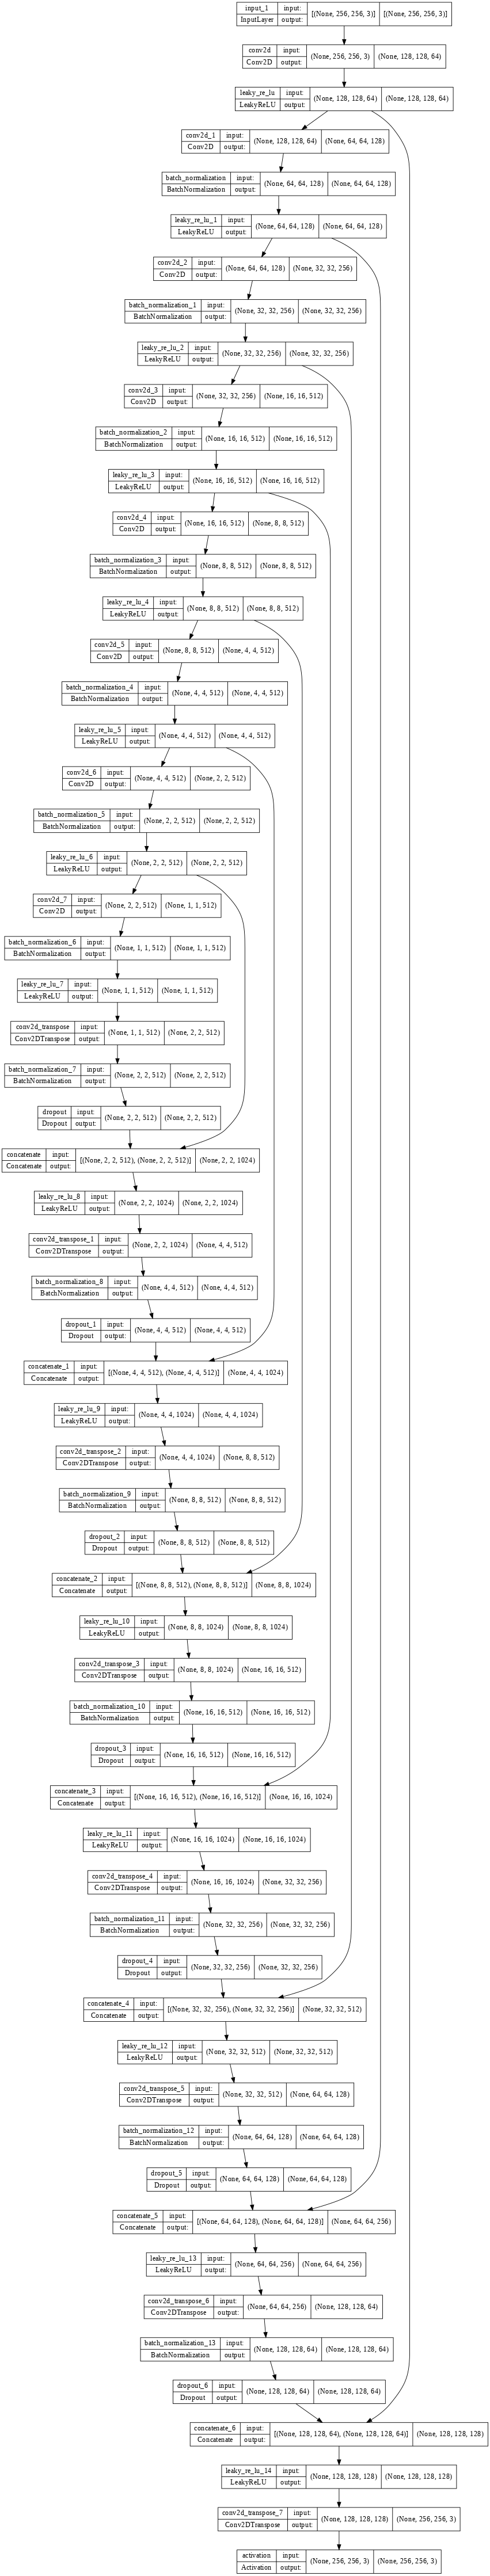

In [ ]:
gen = generator((256,256,3))
plot_model(gen, show_shapes=True, dpi=64)

### THE DISCRIMINATOR FUNCTION

In [ ]:
def discriminator(img_shape):
  init = RandomNormal(stddev = 0.02) # weight initialization
  src_shape = Input(shape = img_shape)  #Image source input
  tar_shape = Input(shape = img_shape)  #Image target input
  merged = Concatenate()([src_shape, tar_shape]) 
  dr = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged) #C(4x4x64) s2
  dr = LeakyReLU(alpha=0.2)(dr)
  dr = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(dr) #C(4x4x128) s2
  dr = BatchNormalization()(dr)
  dr = LeakyReLU(alpha=0.2)(dr)
  dr = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(dr) #C(4x4x256) s2
  dr = BatchNormalization()(dr)
  dr = LeakyReLU(alpha=0.2)(dr)
  dr = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(dr) #C(4x4x512) s2
  dr = BatchNormalization()(dr)
  dr = LeakyReLU(alpha=0.2)(dr)
  dr = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(dr) #C(4x4x512) s1
  dr = BatchNormalization()(dr)
  dr = LeakyReLU(alpha=0.2)(dr)
  dr = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(dr) #C(4x4x512) s1
  dr = BatchNormalization()(dr)
  dr = LeakyReLU(alpha=0.2)(dr)  
  dr = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(dr) 
  dr = Activation('sigmoid')(dr)
  
  model = Model([src_shape, tar_shape], dr) 
  opt = Adam(lr=0.0002, beta_1=0.5) #Adam optimizer
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


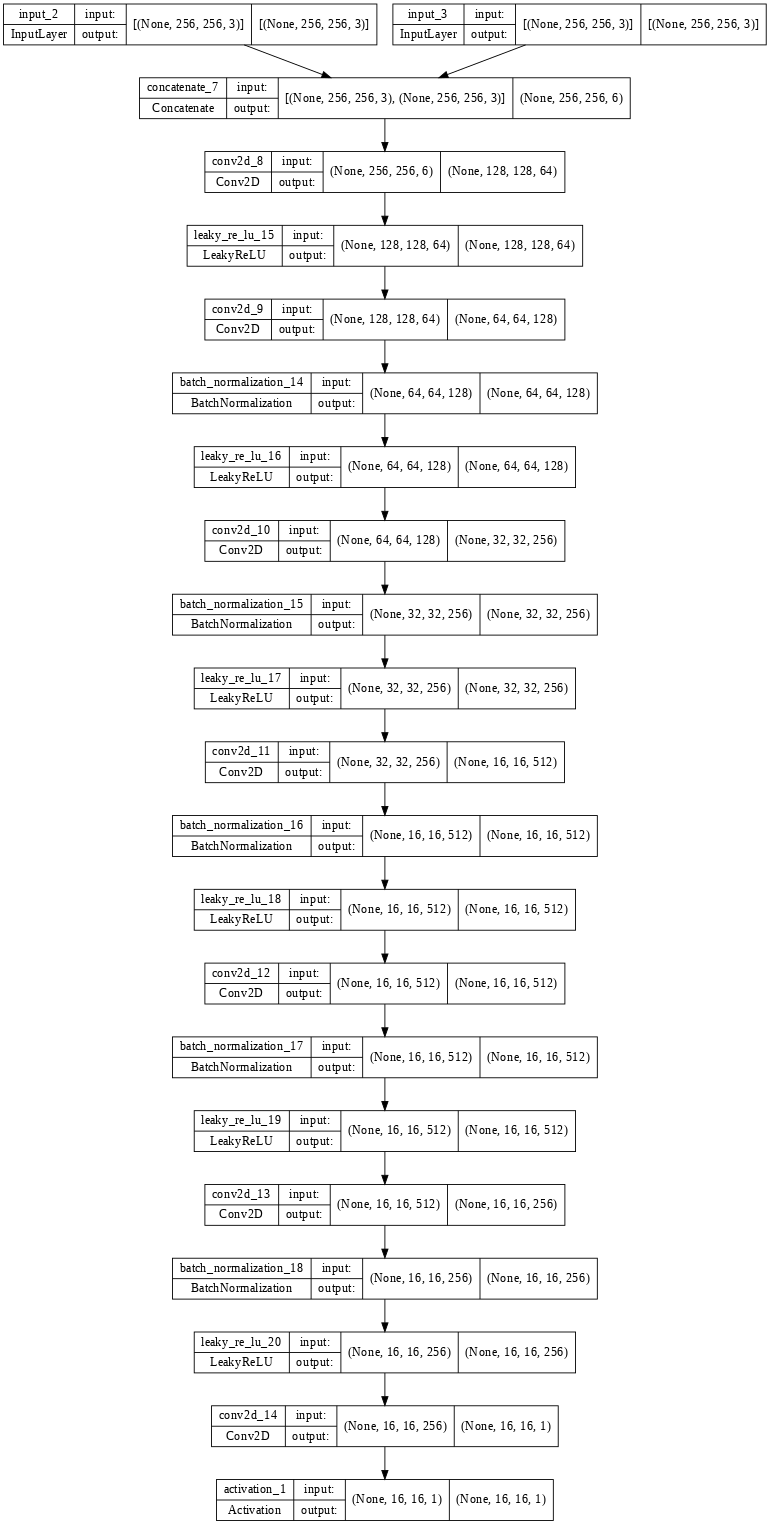

In [ ]:
disc = discriminator((256,256,3))
plot_model(disc, show_shapes=True, dpi=64)

**GAN is defined here by combining the generator and discriminator with no trainable weights.**

In [ ]:
def gan(gen_model, disc_model, input_shape):
  for layer in disc_model.layers: #It creates weigths of discriminator non trainable
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
  
  input_shape = Input(shape = input_shape) #Image input shape
  gen_out = gen_model(input_shape)
  disc_out = disc_model([input_shape, gen_out])

  model = Model(input_shape, [disc_out, gen_out])
  opt = Adam(lr=0.0002, beta_1=0.5) #Adam optimizer
  model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = opt, loss_weights = [1,100])
  return model

**This function generates original random samples, label it with one indicating as real and return generated original data with labels**

In [ ]:
def original_data(data, n, shape):
	train_A, train_B = data
	i = np.random.randint(0, train_A.shape[0], n)
	a1, a2 = train_A[i], train_B[i]
	b = np.ones((n, shape, shape, 1))
	return [a1, a2], b

**This function generates dummy random samples, label it with zero indicating as fake and return generated dummy data with labels**

In [ ]:
def dummy_data(gen_model, data, shape):
	a = gen_model.predict(data)
	b = np.zeros((len(a), shape, shape, 1))
	return a, b

**It briefs the performance by plotting the result along with real input and saves the plotted image & model in the current path.**

In [ ]:
def result_outline(x, gen_model, dataset, n = 3):
	[real_A, real_B], _ = original_data(dataset, n, 1)
	fake_B, _ = dummy_data(gen_model, real_A, 1)
	real_A = (real_A + 1) / 2.0  #it scales all the pixels from [-1,1] --> [0,1]
	real_B = (real_B + 1) / 2.0
	fake_B = (fake_B + 1) / 2.0
	
	#Visualize original source image
	for i in range(n):
		plt.subplot(3, n, 1 + i)
		plt.axis('off')
		plt.imshow(real_A[i])
	
	#Visualize generated target image
	for i in range(n):
		plt.subplot(3, n, 1 + n + i)
		plt.axis('off')
		plt.imshow(fake_B[i])
	
	#Visualize original target image
	for i in range(n):
		plt.subplot(3, n, 1 + n*2 + i)
		plt.axis('off')
		plt.imshow(real_B[i])
	
	#Store the plot of generated results
	file_1 = 'plot_%d.png' % (x+1)
	plt.savefig(file_1)
	plt.close()
	
	#Store the generator model
	file_2 = 'model_%d.h5' % (x+1)
	gen_model.save(file_2)
	print('>Saved: %s and %s' % (file_1, file_2))

### Training the model

**Function will train the dataset and print the loss at every epoch**

In [ ]:
loss_1, loss_2, gan_loss = [],[],[]
def training_image(disc_model, gen_model, gan_model, dataset, epochs = 50, batch = 1):
	patch = disc_model.output_shape[1]
	train_A, train_B = dataset
	batch_per_epoch = int(len(train_A) / batch)
	steps = batch_per_epoch * epochs
	
	for i in range(steps):
		[real_A, real_B], y_real = original_data(dataset, batch, patch)
		fake_B, y_fake = dummy_data(gen_model, real_A, patch)

		loss1 = disc_model.train_on_batch([real_A, real_B], y_real)
		loss2 = disc_model.train_on_batch([real_A, fake_B], y_fake)
		ganloss, _, _ = gan_model.train_on_batch(real_A, [y_real, real_B])
		
		loss_1.append(loss1)
		loss_2.append(loss2)
		gan_loss.append(ganloss)	
		print('>%d, Loss_1[%.4f] Loss_2[%.4f] GAN Loss[%.4f]' % (i+1, loss1, loss2, ganloss))
		
		if (i+1) % (batch_per_epoch * 10) == 0:
			result_outline(i, gen_model, dataset)

**All the models will be defined.**

In [ ]:
image_shape = source_img.shape[1:]

disc_model = discriminator(image_shape)
gen_model = generator(image_shape)
gan_model = gan(gen_model, disc_model, image_shape)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**This function preprocessed the data by rescaling from (0,255) --> (-1,1)**

In [ ]:
def preprocessor(dataset):
	return [((dataset[0] - 127.5) / 127.5), ((dataset[1] - 127.5) / 127.5)]

**Data will be capsulated.**

In [ ]:
#Capsulate the data
dataset = [source_img, target_img]

**Stores the preprocessed dataset in data variable**

In [ ]:
data = preprocessor(dataset)

**Initiate the time of training, starts the training, and evaluate the execution time after training gets completed**

In [ ]:
start_time = datetime.now() #time starts

training_image(disc_model, gen_model, gan_model, data, epochs = 10, batch = 1) #train the model with 10 epochs

end_time = datetime.now() #time stops
print(f'Execution Time of Training: {end_time - start_time}')

Streaming output truncated to the last 5000 lines.
>5964, Loss_1[0.0063] Loss_2[0.0208] GAN Loss[20.6477]
>5965, Loss_1[0.0105] Loss_2[0.0251] GAN Loss[10.2294]
>5966, Loss_1[0.0053] Loss_2[0.0213] GAN Loss[13.6403]
>5967, Loss_1[0.0043] Loss_2[0.0207] GAN Loss[14.9360]
>5968, Loss_1[0.3140] Loss_2[0.1118] GAN Loss[10.5737]
>5969, Loss_1[0.0060] Loss_2[0.3057] GAN Loss[9.8241]
>5970, Loss_1[0.1369] Loss_2[0.0249] GAN Loss[10.6961]
>5971, Loss_1[0.0120] Loss_2[0.1873] GAN Loss[14.5771]
>5972, Loss_1[0.0057] Loss_2[0.0214] GAN Loss[15.2158]
>5973, Loss_1[0.0049] Loss_2[0.0206] GAN Loss[11.3922]
>5974, Loss_1[0.0132] Loss_2[0.0199] GAN Loss[12.3256]
>5975, Loss_1[0.0068] Loss_2[0.0817] GAN Loss[16.5044]
>5976, Loss_1[0.0050] Loss_2[0.0209] GAN Loss[15.0540]
>5977, Loss_1[1.5974] Loss_2[0.0312] GAN Loss[9.1795]
>5978, Loss_1[0.0054] Loss_2[0.0397] GAN Loss[30.8717]
>5979, Loss_1[0.0122] Loss_2[0.0494] GAN Loss[10.4606]
>5980, Loss_1[0.0074] Loss_2[0.0360] GAN Loss[16.5226]
>5981, Loss_1[0.

**Load the saved model to predict and evaluate the loss**

In [ ]:
model = load_model('./model_10960.h5')

**Load the validation dataset and preprocess the data**

In [ ]:
[val_source, val_target] = load_dataset('./maps/val/')
val_dataset = [val_source, val_target]

In [ ]:
val_data = preprocessor(val_dataset)

**Function plots the predicted result with original data**

In [ ]:
def show_results(source, pred, target):
		plt.figure(figsize=(10,8))
		img_batch = np.vstack((source, pred, target))
		img_batch = (img_batch + 1) / 2.0
		legend = ['Source', 'Generated', 'Target']
		for i in range(len(img_batch)):
			plt.subplot(1, 3, 1 + i)
			plt.axis('off')
			plt.imshow(img_batch[i])
			plt.title(legend[i])
		plt.show()

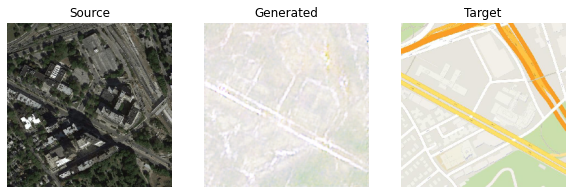

In [ ]:
[x, y] = val_data
i = np.random.randint(0, len(x), 1)
src_img, tar_img = x[i], y[i] 
pred_img = model.predict(src_img)
show_results(src_img, pred_img, tar_img)

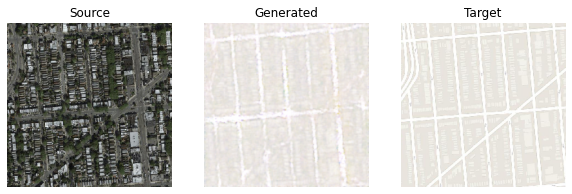

In [ ]:
[x, y] = val_data
i = np.random.randint(0, len(x), 1)
src_img, tar_img = x[i], y[i] 
pred_img = model.predict(src_img)
show_results(src_img, pred_img, tar_img)

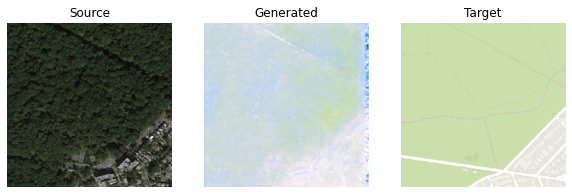

In [ ]:
[x, y] = val_data
i = np.random.randint(0, len(x), 1)
src_img, tar_img = x[i], y[i] 
pred_img = model.predict(src_img)
show_results(src_img, pred_img, tar_img)

**Visualization of Loss**

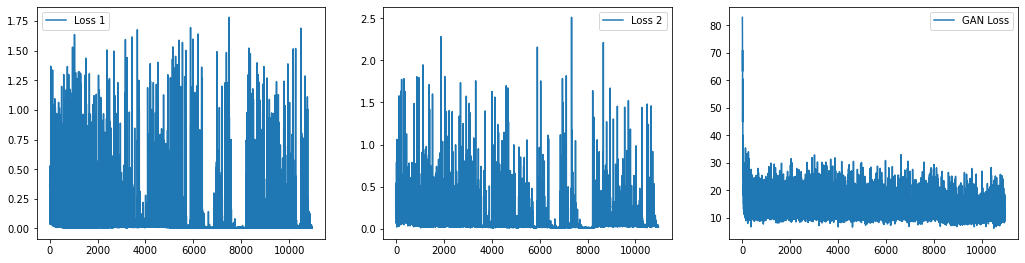

In [29]:
plt.figure(figsize=(30,35))
ax = plt.subplot(7,5,1); plt.plot(loss_1,label='Loss 1'); plt.legend()
ax = plt.subplot(7,5,2); plt.plot(loss_2,label='Loss 2'); plt.legend()
ax = plt.subplot(7,5,3); plt.plot(gan_loss,label='GAN Loss'); plt.legend()
plt.show()

**Create a dataframe of losses**

In [30]:
df = pd.DataFrame({'Loss 1': loss_1, 'Loss 2': loss_2, 'GAN Loss': gan_loss})
df.head()

,Loss 1,Loss 2,GAN Loss
0,0.371503,0.540506,82.817566
1,0.347036,0.484943,80.963638
2,0.294130,0.464554,81.141769
3,0.324719,0.417115,75.409340
4,0.296251,0.419366,74.808174


In [35]:
df.mean()

Loss 1       0.083661
Loss 2       0.087601
GAN Loss    13.181303
dtype: float64

**Store the loss dataframe for further comparison**

In [31]:
df.to_csv('Model_final')